In [1]:
import torch
import detectron2

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import os, json, cv2, random
import matplotlib.pyplot as plt
%matplotlib inline

# Import image processing
from skimage import measure
from skimage import img_as_float
from scipy.spatial import ConvexHull

# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [2]:
from detectron2.structures import BoxMode
def getCellDicts(imgDir, baseDir):
# Get training information
    imgs = os.listdir(imgDir)
    imgs = [img for img in imgs if img.endswith('.csv')]

    # Gather information for each image
    datasetDicts = []
    for idx, img in enumerate(imgs):
        # Information for the whole image
        record = {}
        imgBase = '_'.join(img.split('_')[1:])[:-4]
        phaseContrastName = os.path.join(baseDir, 'PhaseContrast','PhaseContrast_'+imgBase+'.jpg')
        height, width = cv2.imread(phaseContrastName).shape[:2]

        record['file_name'] = phaseContrastName
        record['image_id'] = idx
        record['height'] = height
        record['width'] = width

        # Cell information is stored in a .csv
        # Load the corresponding image, and store its information
        annos = pd.read_csv(os.path.join(imgDir, img))
        imgMaskName = os.path.join(baseDir, 'MasksLabeled', 'MasksLabeled_'+imgBase+'.tif')
        imgMask = cv2.imread(imgMaskName, cv2.IMREAD_UNCHANGED)
        objs = []
        for maskLabel, fluorescence in zip(annos['maskLabel'], annos['fluorescence']):
            # Contour converts the mask to
            contours = measure.find_contours(img_as_float(imgMask==maskLabel), .5)
            hull = []
            for contour in contours:
                hull+=contour[ConvexHull(contour).vertices].tolist()
            hull = np.array(hull)[ConvexHull(hull).vertices]

            px = hull[:,1]
            py = hull[:,0]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        datasetDicts.append(record)
    return datasetDicts

In [3]:
if "cellMorph_train" in DatasetCatalog:
    DatasetCatalog.remove("cellMorph_train")
    
imgDir = './AG2021/MasksFinal/Train'
baseDir = './AG2021'
inputs = [imgDir, baseDir]

DatasetCatalog.register("cellMorph_" + "train", lambda x=inputs: getCellDicts(inputs[0], inputs[1]))
MetadataCatalog.get("cellMorph_" + "train").set(thing_classes=["cell"])

imgDir = './AG2021/MasksFinal/Validate'
baseDir = './AG2021'
inputs = [imgDir, baseDir]

DatasetCatalog.register("cellMorph_" + "Validate", lambda x=inputs: getCellDicts(inputs[0], inputs[1]))
MetadataCatalog.get("cellMorph_" + "Validate").set(thing_classes=["cell"])

cell_metadata = MetadataCatalog.get("cellMorph_train")

In [1]:
# Look at training curves in tensorboard:
# %load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir output --port 6060

In [5]:
cfg = get_cfg()
if not torch.cuda.is_available():
    print('CUDA not available, resorting to CPU')
    cfg.MODEL.DEVICE='cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("cellMorph_Train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
cfg.OUTPUT_DIR = './output/AG2021'

CUDA not available, resorting to CPU


In [6]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[07/08 10:30:09 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

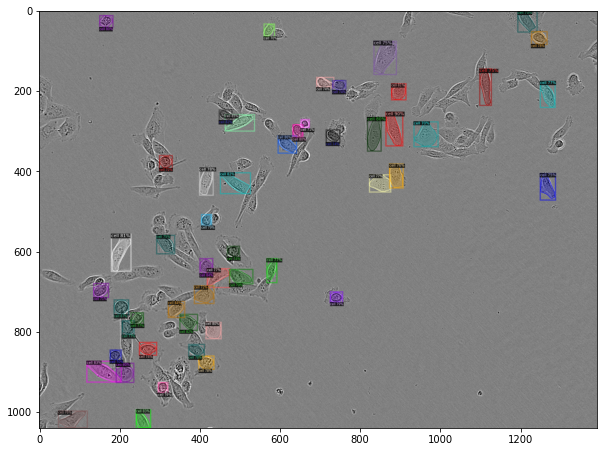

In [17]:
from detectron2.utils.visualizer import ColorMode

imgDir = './AG2021/MasksFinal/Validate'
baseDir = './AG2021'

dataset_dicts = getCellDicts(imgDir, baseDir)
for d in random.sample(dataset_dicts, 1):    
    # im = cv2.imread(d["file_name"])
    im = cv2.imread(fname)
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=cell_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(10,10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

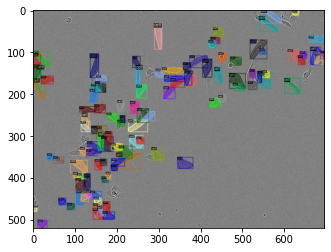

In [12]:
imgDir = './AG2021/MasksFinal/Train'
baseDir = './AG2021'
dataset_dicts = getCellDicts(imgDir, baseDir)

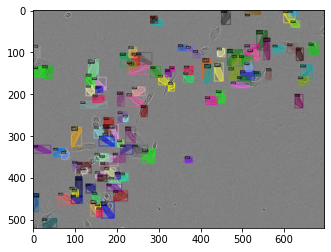

In [14]:
random.seed(1234)
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=cell_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [16]:
fname = d["file_name"]